In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt  #Graphics

### Load the data

Load the MNIST data set from two `.csv` files into two variables. 
Print the number of data points in the training and test sets.
Print the number of object in eacsh class.

In [16]:
from sklearn. preprocessing import LabelEncoder

spotify = 1
mnist = 0

if spotify:
    train = pd.read_csv("data/spotify/spotify_songs.csv") 
    train.dropna(inplace=True)
    train_all = train
    train = train.drop([
        'track_name','track_album_name','track_id','playlist_id','track_album_id', 
        'playlist_name', 'track_album_release_date',
        #'track_popularity','track_album_release_date',
        #'track_artist','loudness','playlist_subgenre',
        #'duration_ms','year','instrumentalness','mode','key'
        ], axis=1)
    le= LabelEncoder()
    train.playlist_genre = le.fit_transform(train.playlist_genre)
    train.playlist_subgenre = le.fit_transform(train.playlist_subgenre)
    train.track_artist = le.fit_transform(train.track_artist)
    print(train.playlist_genre.value_counts().sort_index())
if mnist:
    train = pd.read_csv("data/mnist_train.csv")
    train.dropna(inplace=True)
    print(train.iloc[:,0].value_counts().sort_index())
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))



0    6043
1    5153
2    5507
3    5431
4    5743
5    4951
Name: playlist_genre, dtype: int64
Training dataset has 32828 observations and 16 variables


### Slipt the data

Let us focus on the training data set. 
Split the 60000 observation into four equal-size random subsets, 
1. ${\cal D}_{train}$ to train the classifier,
2. ${\cal D}_{val}$ to train the localization function, 
3. ${\cal D}_{cal}$ to compute the quantiles,
4. ${\cal D}_{test}$ to evaluate the predictions sets.

We normalize the pixel values using the (column) means and standard deviations.

In [20]:
from sklearn.decomposition import PCA
dataset = train

if mnist:
    df_x = dataset.iloc[:,1:].to_numpy(dtype=float)
    df_y = dataset.iloc[:, 0].to_numpy(dtype=int)
    

if spotify:
    df_x = np.concatenate((dataset.iloc[:,0:2].to_numpy(dtype=float), dataset.iloc[:,5:].to_numpy(dtype=float)), axis = 1)
    df_y = dataset.iloc[:, 2].to_numpy(dtype=int)

df_x = np.array([df_x[i] - np.mean(df_x[i, :])/(1e-8 + np.std(df_x[i, :])) for i in range(len(df_x))])
np.random.seed(1234) 

indexes = np.random.choice(len(df_x), len(df_x), replace=False)
stops = [int(i * len(indexes)/4) for i in range(5)]
X, y = [df_x[indexes[stops[i]:stops[i + 1]]] for i in range(4)], [df_y[indexes[stops[i] : stops[i + 1]]] for i in range(4)]

print("data set shapes:")
names = ['train', 'val', 'cal', 'test']
for ix in range(len(X)):
    print(names[ix], X[ix].shape, y[ix].shape)
Xall, yall = X, y

data set shapes:
train (8207, 13) (8207,)
val (8207, 13) (8207,)
cal (8207, 13) (8207,)
test (8207, 13) (8207,)


### Train the classifier

Train a NN classifier on ${\cal D}_{train}$. 
The error rate on the four sets is resonable.

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100)) 
nn = RandomForestClassifier() 

iset = 0
nn.fit(Xall[iset], yall[iset])
print(nn)
for iset in range(4):   
    probs = nn.predict_proba(Xall[iset])
    ER = 1 - sum([1 * (yall[iset][i] == np.argmax(probs[i])) for i in range(len(probs))])/len(probs)
    print(names[iset], "ER =", ER)

RandomForestClassifier()
train ER = 0.02510052394297546
val ER = 0.4957962714755696
cal ER = 0.4975021323260631
test ER = 0.49067868892408917


In [25]:
def increaseTemperature(p, T):
    if T != 0:
        p = [[np.exp(f[i]/T) for i in range(len(p[0]))] for f in p]
    pt = [[s/sum(pi) for s in pi] for pi in p]
    return pt

T = 0
for iset in range(4):   
    probs = increaseTemperature(nn.predict_proba(Xall[iset]), T)
    ER = 1 - sum([1 * (yall[iset][i] == np.argmax(probs[i])) for i in range(len(probs))])/len(probs)
    
    wrong = sum([probs[i][yall[iset][i]] <.01 for i in range(len(probs))])
    yWrong = [(yall[iset][i], np.argmax(probs[i]), np.round(max(probs[i]), 2)) for i in range(len(probs)) if probs[i][yall[iset][i]] <.1 ]
    print(names[iset], "ER =", ER)
    print(names[iset], "wrong =", wrong)
    print(yWrong[:10])


train ER = 0.02510052394297546
train wrong = 0
[]
val ER = 0.4957962714755696
val wrong = 32
[(3, 4, 0.24), (1, 4, 0.56), (3, 1, 0.48), (1, 3, 0.24), (1, 0, 0.39), (3, 1, 0.52), (2, 0, 0.28), (3, 5, 0.27), (0, 2, 0.8), (2, 3, 0.48)]
cal ER = 0.4975021323260631
cal wrong = 34
[(0, 2, 0.5), (1, 5, 0.47), (1, 0, 0.66), (1, 0, 0.37), (0, 5, 0.46), (2, 1, 0.46), (1, 3, 0.43), (1, 4, 0.52), (0, 2, 0.53), (3, 1, 0.48)]
test ER = 0.49067868892408917
test wrong = 26
[(0, 1, 0.75), (3, 5, 0.38), (0, 5, 0.39), (2, 3, 0.39), (0, 2, 0.41), (3, 5, 0.36), (0, 3, 0.25), (0, 5, 0.31), (2, 5, 0.37), (3, 2, 0.37)]


### Train the localizer 1

The goal is to train a model such that 
$$
B  = A -  g(X, Y, f), \quad  g(X, Y, f) \sim A
$$
or
$$
B  = \frac{A}{\gamma +  g(X, Y, f)}, \quad  g(X, Y, f) \sim A
$$
We minimize 
$$
{\rm E}_{XY} \| g(X, Y, f) - A \|^2 
$$

iset: RSS= 1 0.04158646371603318
iset: RSS= 2 0.043827231614576065
iset: RSS= 3 0.0443494855132228


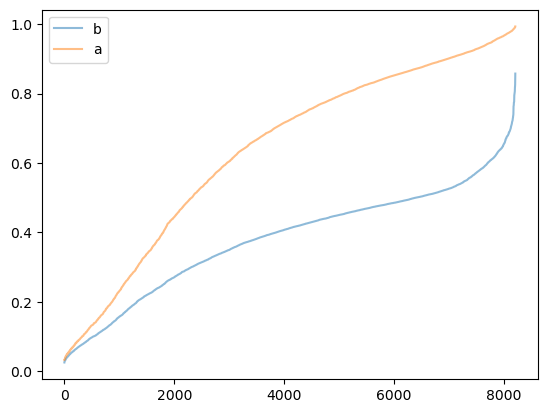

In [41]:
from sklearn.ensemble import RandomForestRegressor  
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
#Split the train dataset and reduce dimensions
def reduceDimensions(X, d):
    pca = PCA(n_components = d)
    pca.fit(X)
    return pca.transform(X)

def entropy(p):
    return -sum([s * np.log(s + .001) for s in p])
    
def Brf(g, a, z, gamma):
    s = g.predict(z)
    return a/(gamma + s)
    #return a - s

def trainRegressor(a, z):
    g = RandomForestRegressor(n_estimators=100, bootstrap=True, max_depth=20, max_samples=100) 
    #g = LinearRegression()
    #g = KNeighborsRegressor(n_neighbors=K)
    g.fit(z, a)
    return g

T = .2
if spotify:
    d = len(Xall[0][0])
if mnist:
    d = 20
distribution = 1
samples = 0
for iset in [1, 2, 3]:
    model = nn
    probs = increaseTemperature(nn.predict_proba(Xall[iset]), T)
    Xreduced = reduceDimensions(Xall[iset], d)
    X = np.array([Xreduced[i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])
    Y = np.array([yall[iset][i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr]).reshape(-1, 1)
    f = np.array([probs[i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])
    a = np.array([1 - probs[i][yall[iset][i]] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])#.reshape(-1, 1)    
    e = np.array([entropy(probs[i]) for i in range(len(Xall[iset])) if entropy(probs[i])>thr]).reshape(-1, 1)
    
    z = np.concatenate((np.ones([len(f), 1]), X, f, Y, e), axis = 1)
    if (iset == 1): g = trainRegressor(a, z)
    print("iset: RSS=",  iset, sum((a-g.predict(z))**2)/len(Y))
    if distribution and iset == 1:
        plt.plot(np.sort(Brf(g, a, z, gamma), axis = 0), alpha=0.5, label='b')
        plt.plot(np.sort(a, axis = 0), alpha=0.5, label='a')
    if samples:
        if (iset in [1, 2, 3]):
            plt.plot(a, g.predict(z), '*', alpha=0.5, label=str(iset))
            
plt.legend()              
plt.show()


iset, ER, Y[1]= 2 [0.49750213] [5]
(8207,)
k, Ca, Cb, Y 3618 [0, 1, 2, 3, 4, 5] [0, 1, 2, 3, 4, 5] [4]
alpha, TP, FP, FN, F1 0.01 [8107, 8110] [38377, 37993] [100, 97] [0.2964655976303231, 0.29865586448167925]
iset, ER, Y[1]= 2 [0.49750213] [5]
(8207,)
k, Ca, Cb, Y 8079 [0, 1, 2, 3, 4, 5] [0, 1, 2, 3, 4, 5] [3]
alpha, TP, FP, FN, F1 0.05 [7796, 7769] [32069, 31906] [411, 438] [0.3243468131136628, 0.32450607744037424]
iset, ER, Y[1]= 2 [0.49750213] [5]
(8207,)
k, Ca, Cb, Y 7042 [3, 4] [1, 3, 4] [3]
alpha, TP, FP, FN, F1 0.32 [5621, 5620] [8574, 8678] [2586, 2587] [0.5018301937327024, 0.4994445678738058]
[0.2964655976303231, 0.3243468131136628, 0.5018301937327024]


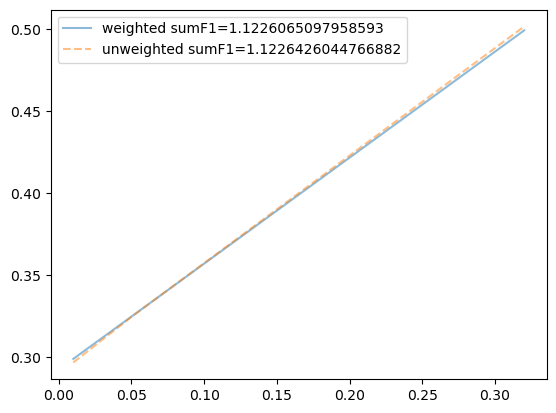

In [42]:
tryAlpha = [0.01, 0.05, 0.32]
model = nn
gamma = 1
auc = [], []    
for alpha in tryAlpha:
    iset = 2
    probs = increaseTemperature(nn.predict_proba(Xall[iset]), T)
    Xreduced = reduceDimensions(Xall[iset], d)
    X = np.array([Xreduced[i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])
    Y = np.array([yall[iset][i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr]).reshape(-1, 1)
    f = np.array([probs[i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])
    a = np.array([1 - probs[i][yall[iset][i]] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])#.reshape(-1, 1)    
    e = np.array([entropy(probs[i]) for i in range(len(Xall[iset])) if entropy(probs[i])>thr]).reshape(-1, 1)
    print("iset, ER, Y[1]=",  iset, sum([Y[i]!=np.argmax(f[i]) for i in range(len(Y))])/len(Y), Y[0])
    z = np.concatenate((np.ones([len(f), 1]), X, f, Y, e), axis = 1)

    acal = a
    bcal = Brf(g, acal, z, gamma)    
    print(bcal.shape)
    QA = np.sort(acal, axis = 0)[int(np.ceil((len(acal) + 1) * (1 - alpha)))-1]
    QB = np.sort(bcal, axis = 0)[int(np.ceil((len(bcal) + 1) * (1 - alpha)))-1]
    iset = 3
    probs = increaseTemperature(nn.predict_proba(Xall[iset]), T)
    Xreduced = reduceDimensions(Xall[iset], d)
    X = np.array([Xreduced[i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])
    Y = np.array([yall[iset][i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr]).reshape(-1, 1)
    f = np.array([probs[i] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])
    a = np.array([1 - probs[i][yall[iset][i]] for i in range(len(Xall[iset])) if entropy(probs[i])>thr])#.reshape(-1, 1)    
    e = np.array([entropy(probs[i]) for i in range(len(Xall[iset])) if entropy(probs[i])>thr]).reshape(-1, 1)
    z = np.concatenate((np.ones([len(f), 1]), X, f, Y, e), axis = 1)

    atest = [(1 - f[:, i]).reshape(-1, 1) for i in range(len(f[0]))]
    zi = [np.concatenate((np.ones([len(f), 1]), X, f, Y, e), axis = 1) for i in range(len(f[0]))]
    btest = [Brf(g, (1 - f[:, i]), zi[i], gamma) for i in range(len(f[0]))]
    intervalsA = [[j for j in range(len(atest)) if atest[j][i] <= QA] for i in range(len(atest[0]))]
    intervalsB = [[j for j in range(len(btest)) if btest[j][i] <= QB] for i in range(len(btest[0]))]
    k = np.random.randint(len(btest[0]))
    print("k, Ca, Cb, Y", k, intervalsA[k], intervalsB[k], Y[k])
        
    TP, FP, TN, FN, F1 = [0, 0], [0, 0],[0, 0], [0, 0], [0, 0]
    intervalsAll = intervalsA, intervalsB
    for iModel in [0, 1]:
        for i in range(len(intervalsA)):
            intervals = intervalsAll[iModel][i]
            y = Y[i]
            positives = [j for j in range(10) if j in intervals]
            TP[iModel] = TP[iModel] + sum([1 for j in positives if j == y])
            FP[iModel] = FP[iModel] + sum([1 for j in positives if j != y])
            negatives = [j for j in range(10) if j not in intervals]
            TN[iModel] = TN[iModel] + sum([1 for j in negatives if j != y])  
            FN[iModel] = FN[iModel] + sum([1 for j in negatives if j == y]) 
        F1 = 2 * TP[iModel]/(2 * TP[iModel] + FP[iModel] + FN[iModel])
        auc[iModel].append(F1)
    print('alpha, TP, FP, FN, F1', alpha, TP, FP, FN, [auc[0][-1], auc[1][-1]])
    
s = np.sum(auc, axis=1)
print(auc[0])
plt.plot([u for u in tryAlpha], [x for x in auc[1]], '-', label='weighted sumF1='+str(s[1]) , alpha=0.5)
plt.plot([u for u in tryAlpha], [x for x in auc[0]], '--', label='unweighted sumF1='+str(s[0]), alpha=0.5)
plt.legend()
plt.show()

In [ ]:

def trainRegressor(z, a):
    g = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(10, 10, 10))
    g.fit(z, a)
    return g

for iset in [1, 2, 3]:
    model = nn
    X = Xall[iset]
    Y = yall[iset]
    probs = model.predict_proba(X)
    eps = .001
    #probs = [p + eps * np.random.rand(len(p)) for p in probs]
    #probs = [p/sum(p) for p in probs]
    
    #a = np.array([(1 - probs[i][Y[i]]) for i in range(len(Y))])
    a = np.array([(1 - probs[i][Y[i]]) + 1/(1 + probs[i][Y[i]]) * entropy(probs[i]) for i in range(len(Y))])
    print(a.shape)
    ia = [i for i in range(len(a))]# if a[i]>0.05 and a[i]<.95]
    print(len(ia))
    aTrain = a[ia]
    XTrain = X[ia, :]
    probsTrain = probs[ia, :]
    e = np.array([entropy(p) for p in probsTrain]).reshape(-1, 1)
    yTrain = Y[ia].reshape(-1, 1)
    zTrain = np.concatenate((probsTrain, yTrain, e), axis = 1)
    #a = np.array([entropy(probs[i]) for i in range(len(Y))])
    if (iset == 1):
        #g = trainRegressor(XTrain, aTrain)
        g = trainRegressor(zTrain, aTrain)
    
    e = np.array([entropy(p) for p in probs]).reshape(-1, 1)
    Y = Y.reshape(-1, 1)
    z = np.concatenate((probs, Y, e), axis = 1)
    print((e == 0).shape)
    aPredict = g.predict(z)
    aPredict  = np.array([ 0 + aPredict[i] * (e[i] >.1) + 1 * (np.argmax(probs[i]) != Y[i]) * (e[i] <.1) for i in range(len(aPredict))])
    print(aPredict.shape)
    ER = sum([(a[i] - aPredict[i])**2 for i in range(len(aPredict))])
    print(names[iset], "ER = ", ER)
    plt.plot(a, aPredict, '*', alpha = .3, label=names[iset])

plt.legend()              
plt.show()


In [ ]:
for iset in [0 , 1, 2, 3]:
    model = nn
    X = Xall[iset]
    Y = yall[iset]
    probs = model.predict_proba(X)
    a = np.array([(1 - probs[i][Y[i]]) for i in range(len(Y))])    
    e = np.array([entropy(p) for p in probs]).reshape(-1, 1)
    Y = Y.reshape(-1, 1)
    z = np.concatenate((probs, Y, e), axis = 1)
    print((e == 0).shape)
    aPredict = g.predict(z)
    aPredict  = np.array([ 0 + aPredict[i] * (e[i] >.1) + 1 * (np.argmax(probs[i]) != Y[i]) * (e[i] <.1) for i in range(len(aPredict))])
    print(aPredict.shape)
    ER = sum([(a[i] - aPredict[i])**2 for i in range(len(aPredict))])
    print(names[iset], "ER = ", ER)
    plt.plot(a, aPredict, '*', alpha = .3, label=names[iset])